In [1]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pushbullet import Pushbullet
from dotenv import load_dotenv
import os

load_dotenv()
try:
    pb = Pushbullet(os.getenv('PUSHBULLET_API_KEY'))
except:
    pb = None

In [2]:
# Read
df = pd.read_excel('Online_Retail.xlsx')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Preprocess
df['Description'] = df['Description'].str.strip()
df.dropna(axis=0, subset=['InvoiceNo'], inplace=True)
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df = df[~df['InvoiceNo'].str.contains('C')]

df = df[~df['Description'].str.contains('Adjust bad debt', case=False, na=False)]


In [4]:
# Group by
purchase_group = df.groupby('InvoiceNo')['Description'].apply(list).reset_index()
purchase_group

,InvoiceNo,Description
0,536365,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET..."
1,536366,"[HAND WARMER UNION JACK, HAND WARMER RED POLKA..."
2,536367,"[ASSORTED COLOUR BIRD ORNAMENT, POPPY'S PLAYHO..."
3,536368,"[JAM MAKING SET WITH JARS, RED COAT RACK PARIS..."
4,536369,[BATH BUILDING BLOCK WORD]
...,...,...
22056,581583,"[LUNCH BAG RED RETROSPOT, 6 CHOCOLATE LOVE HEA..."
22057,581584,"[RED FLOCK LOVE HEART PHOTO FRAME, 6 CHOCOLATE..."
22058,581585,"[BLACK TEA TOWEL CLASSIC DESIGN, ASSORTED BOTT..."
22059,581586,"[LARGE CAKE STAND HANGING STRAWBERY, SET OF 3..."


In [5]:

try:
        
    transactions = purchase_group['Description'].apply(lambda x: [str(item) for item in x if pd.notnull(item)]).tolist()

    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)

    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)


    frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)

    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

    print(rules.head())
except Exception as e:
    print(e)
    if pb:
        pb.push_note('Error', str(e))
    raise e

                         antecedents                        consequents  \
0           (6 RIBBONS RUSTIC CHARM)           (JAM MAKING SET PRINTED)   
1           (JAM MAKING SET PRINTED)           (6 RIBBONS RUSTIC CHARM)   
2           (6 RIBBONS RUSTIC CHARM)  (PACK OF 72 RETROSPOT CAKE CASES)   
3  (PACK OF 72 RETROSPOT CAKE CASES)           (6 RIBBONS RUSTIC CHARM)   
4           (6 RIBBONS RUSTIC CHARM)         (REGENCY CAKESTAND 3 TIER)   

   antecedent support  consequent support   support  confidence      lift  \
0            0.043289            0.052672  0.010698    0.247120  4.691673   
1            0.052672            0.043289  0.010698    0.203098  4.691673   
2            0.043289            0.059834  0.010788    0.249215  4.165094   
3            0.059834            0.043289  0.010788    0.180303  4.165094   
4            0.043289            0.090159  0.010970    0.253403  2.810622   

   leverage  conviction  zhangs_metric  
0  0.008417    1.258273       0.822460  
1  0

In [6]:

try:
    push = pb.push_note("Apriori", "Done")
except Exception as e:
    print("Error sending pushbullet notification")

frequent_itemsets.to_csv('frequent_itemsets.csv', index=False)

rules.to_csv('association_rules.csv', index=False)


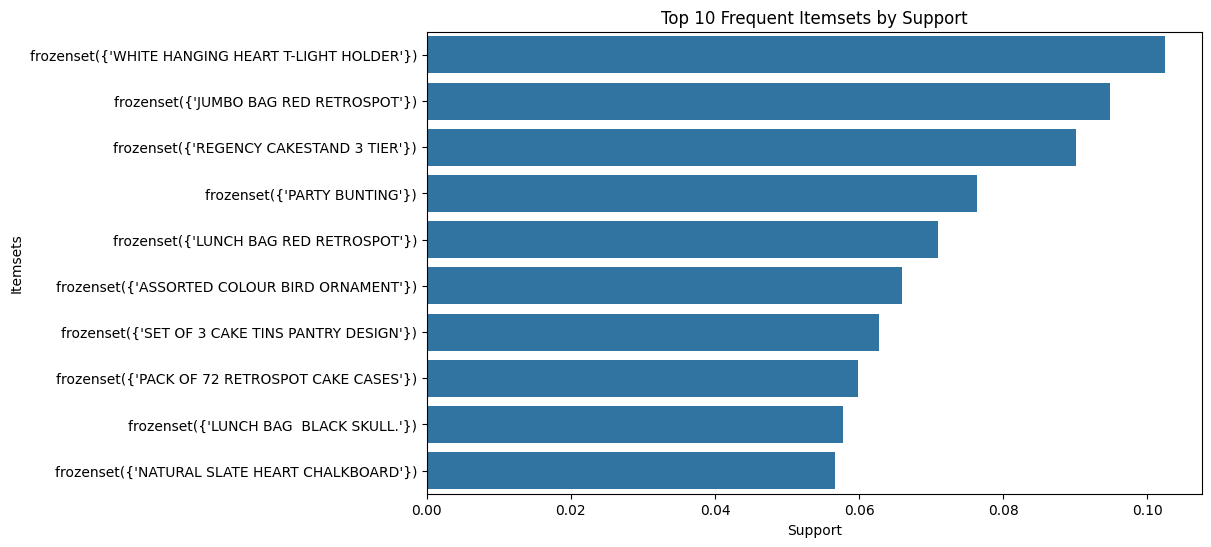

In [7]:
top_itemsets = frequent_itemsets.nlargest(10, 'support')

plt.figure(figsize=(10, 6))
sns.barplot(x='support', y='itemsets', data=top_itemsets)
plt.title('Top 10 Frequent Itemsets by Support')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.show()

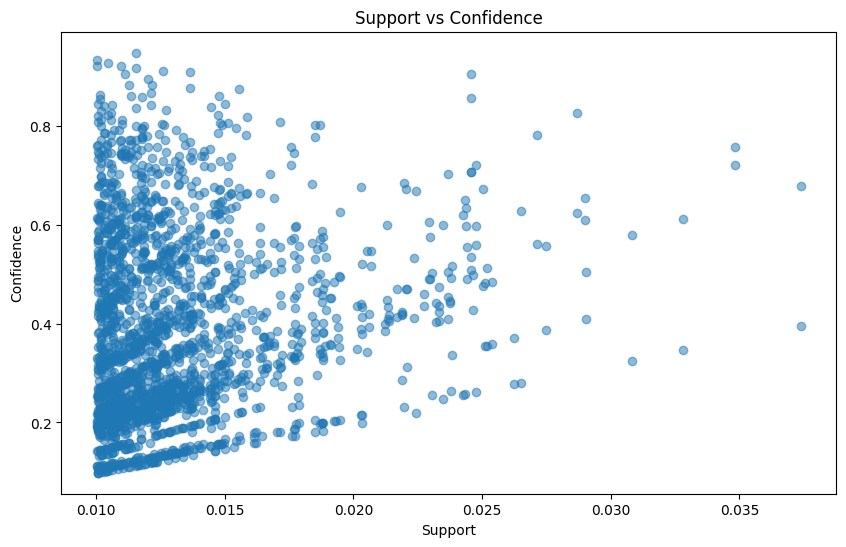

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
plt.title('Support vs Confidence')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.show()

In [9]:
itemsets_matrix = df_encoded.T.dot(df_encoded)
sns.heatmap(itemsets_matrix, cmap="YlGnBu")
plt.title('Heatmap of Itemset Correlations')
plt.show()